In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect tables
Base.prepare(engine)

In [6]:
# View all classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the Database
session = Session(engine)

## View the Database

In [9]:
# get db schema
metadata = MetaData(bind=engine)

metadata.reflect()

dbtables = metadata.tables

### Precipitation Analysis

In [10]:
# Find the most recent date in the data set
from datetime import datetime, timedelta

#dt_mostrecent = session.query(func.max(Measurement.date)).scalar()
dt_mostrecentstr = session.query(func.max(Measurement.date)).order_by(Measurement.date.desc()).first()
dt_mostrecentstr

('2017-08-23',)

In [11]:
# Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data.
dt_mostrecent = dt.datetime.strptime(dt_mostrecentstr[0], '%Y-%m-%d')
qrydate = dt.date(dt_mostrecent.year -1, dt_mostrecent.month, dt_mostrecent.day)


In [12]:
# Select only the 'date and "prcp" values.
sel = [Measurement.date,Measurement.prcp]
qryresult = session.query(*sel).filter(Measurement.date >= qrydate).all()

In [13]:
# Load the query results into a Pandas DF. Explicitly set the column names.
qryresult_df = pd.DataFrame(qryresult,columns=['Date','Precipitation'])
qryresult_df.head()


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [14]:
# Sort the DF values by "date".
qryresult_sorted = qryresult_df.dropna(how='any')
qryresult_sorted = qryresult_sorted.sort_values(['Date'])
# qry_result_sorted = qry_result_sorted.set_index('Date')
qryresult_sorted.head()

,Date,Precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


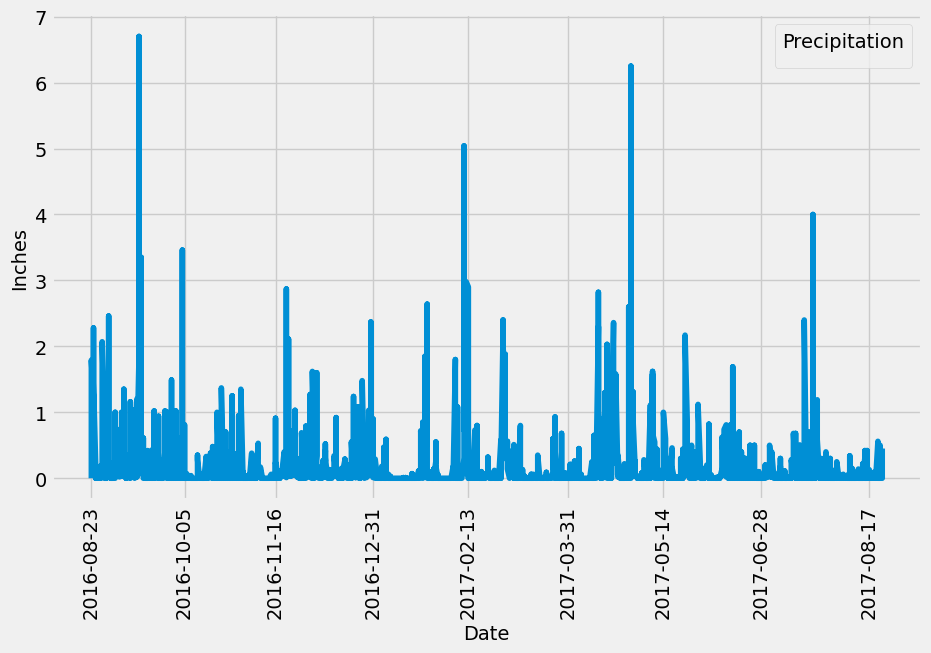

In [15]:
# Plot the results by using the DF plot method, as the following image shows:
plt.figure(figsize=(10, 6))

# Create the line plot
plt.plot(qryresult_sorted['Date'], qryresult_sorted['Precipitation'])
# plt.plot(qryresult_sorted)

# Set the x-axis label and rotate the tick labels
plt.xlabel('Date')
plt.xticks(qryresult_sorted['Date'][::250],rotation=90)

# Set the y-axis label
plt.ylabel('Inches')

plt.legend(title="Precipitation")
# Set the plot title
# plt.tile('Precipitation by Date)

# Display the plot
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
qryresult_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Exploratory Station Analysis


In [17]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


#### Design a query to find the most active stations(that is, the stations that have the most rows). To do so, complete the following steps:

In [18]:
# List the stations and observation counts in descending order.
activeStations = session.query(Measurement.station, func.count()).group_by(Measurement.station).\
order_by(func.count().desc()).all()

for stat, count in activeStations:
    print(stat,count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [19]:
# Answer the following question: which station id has the greatest number of observations?
topStation = session.query(Measurement.station, func.count()).group_by(Measurement.station).\
order_by(func.count().desc()).first()
print(f"Station id with the greatest number of observations: {topStation[0]}")

Station id with the greatest number of observations: USC00519281


#### Design a query that calculates the lowest, highest, and average temperatures that filters on the most active station id found in the previous query.

In [20]:
calc = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostActiveStationInfo = session.query(*calc).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
mostActiveStationInfo

(54.0, 85.0, 71.66378066378067)

#### Design a query to get the previous 12 months of temperature observation(TOBS) data.  To do so, complete the following steps:

In [21]:
# Filter by the station that has the greatest number of observations 
topStation

('USC00519281', 2772)

In [22]:
# Filter by the station that has the greatest number of observations.
from sqlalchemy import desc
str_lastest_tob = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dt_latest_tob = dt.datetime.strptime(str_lastest_tob[0], '%Y-%m-%d')
dt_yearprior = dt.date(dt_latest_tob.year -1, dt_latest_tob.month, dt_latest_tob.day)

prevmonths = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.date >= dt_yearprior).\
    order_by(desc(Measurement.date)).filter(Measurement.station == topStation[0])
prevmonths_df = pd.DataFrame(prevmonths)


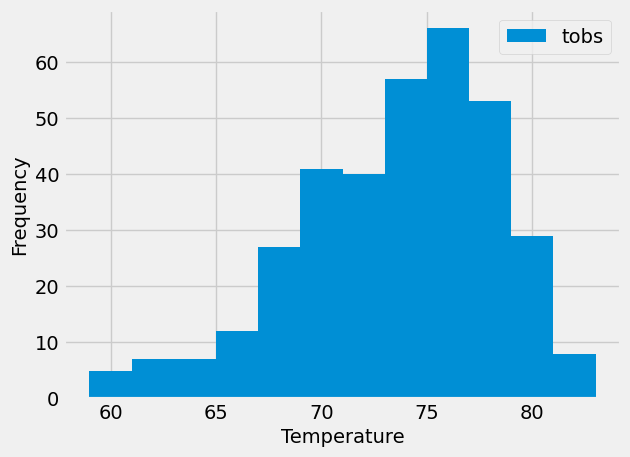

In [23]:
# Plot the results as a histogram with bins=12, as the following image shows:
# Plot the results as a histogram
hist_data = prevmonths_df['tobs']
hist_data.hist(bins = 12)

fontsize = 10
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])

plt.show()

In [24]:
# Close the session
session.close()

## Part 2: Design Your Climate App

In [25]:
# Start at the homepage
# List all the available routes